# Stock Day Trading with PyTorch and LSTM networks

**Created by**: Ng Teng Suan<br>
**Last updated**: 2025-05-25

This project develops a deep learning model using a Long Short-Term Memory (LSTM) network, a type of recurrent neural network implemented in PyTorch to predict daily stock price movements for constituents of the S&P 500 index. The data, obtained from the `yfinance` package, includes historical stock prices and trading volumes. To ensure the stationarity of the input data and stabilize the learning process, the model is trained to predict the direction of price movement rather than the raw price itself. The prediction task is formulated as a binary classification problem, where the target variable indicates whether the stock price will increase (1) or decrease (0) on the following trading day.

The trading strategy based on the model’s predictions is designed to maximize daily average returns. A stock is purchased if the model forecasts a price increase the next day, and the position is liquidated at the end of that day. If a price decrease is predicted, no trade is executed. This simple yet disciplined strategy aims to exploit the model's predictive power to make informed trading decisions while avoiding unnecessary risk when the outlook is negative. To build a robust feature set, the model uses historical data spanning the past five years for all S&P 500 constituents. Alongside raw price and volume data, a variety of technical indicators are engineered to provide the model with richer information that may help uncover meaningful temporal patterns in stock behavior.

To assess the effectiveness of the LSTM model, its performance is compared against two benchmark strategies. The first is a perfect foresight strategy, which represents an idealized upper bound by only initiating trades on days when the next-day return is known to be positive. While this strategy is impossible to implement in reality, it provides a useful reference point for evaluating the potential ceiling of model performance. The second benchmark is a random trading strategy, which simulates unskilled investment behavior by selecting trading days at random with a 50/50 chance of executing trades on each day.

The overarching goal of this project is to evaluate whether LSTM networks can successfully capture temporal dependencies in stock price movements and generate returns that exceed those of naive or idealized strategies. The project also examines the scalability of the approach across the full set of S&P 500 stocks and critically reflects on the challenges and limitations of applying such models in real-world trading environments. The conclusion outlines several directions for future work, including refining the model architecture through techniques such as attention mechanisms or transformer-based designs, integrating alternative data sources such as sentiment or macroeconomic indicators, and improving risk management and execution strategies. Additionally, it proposes expanding the approach toward portfolio-level applications, potentially unlocking broader investment insights beyond individual stock predictions.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Set device to use CUDA if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Step 1: Load and visualize stock data with the `yfinance` package

When importing stock data from the `yfinance` package using the `.download` method, we get five initial features for each stock.

| **Feature** | **Description**                                                                                                                          |
|-------------|------------------------------------------------------------------------------------------------------------------------------------------|
| **Open**    | The price at which the stock started trading when the market opened on a given day.                                                      |
| **High**    | The highest price the stock traded at during the trading session.                                                                        |
| **Low**     | The lowest price the stock traded at during the trading session.                                                                         |
| **Close**   | The last price at which the stock was traded during normal market hours. Often used as the reference price for daily return calculations.|
| **Volume**  | The total number of shares traded during the day. Reflects market activity and liquidity.                                                |

In [2]:
# Get data from past 5 years to current day only
now = datetime.today()
five_years_ago = now - relativedelta(years = 5)
iso8601_5_yrs_ago = five_years_ago.strftime("%Y-%m-%d")

# Select the stock tickers to be downloaded from the Yahoo Finance API (Use AAPL, MSFT and GOOGL as examples)
tickers = ["AAPL", "MSFT", "GOOGL"]

# Download data and display first few rows
df = yf.download(tickers, iso8601_5_yrs_ago)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Price           Close                              High             \
Ticker           AAPL      GOOGL        MSFT       AAPL      GOOGL   
Date                                                                 
2020-05-26  76.970863  70.730331  173.959641  78.795918  71.911687   
2020-05-27  77.306221  70.676102  174.189575  77.452033  70.928397   
2020-05-28  77.340240  70.574585  173.796753  78.601501  71.879344   
2020-05-29  77.264893  71.334953  175.569183  78.044976  71.494689   
2020-06-01  78.215126  71.402130  175.166794  78.336635  71.736036   

Price                         Low                              Open  \
Ticker            MSFT       AAPL      GOOGL        MSFT       AAPL   
Date                                                                  
2020-05-26  178.682996  76.914967  70.632305  173.509339  78.616088   
2020-05-27  174.362038  76.086277  69.398215  169.197956  76.827484   
2020-05-28  176.431489  76.703536  69.621143  172.819516  76.980572   
2020-05-29  176.546435  76.907657  70.462127  172.848224  77.583245   
2020-06-01  175.329667  77.087522  70.775624  173.854221  77.218754   

Price                                 Volume                      
Ticker          GOOGL        MSFT       AAPL     GOOGL      MSFT  
Date                                                              
2020-05-26  71.754936  178.529699  125522000  44590000  36073600  
2020-05-27  70.662168  172.647056  112945200  31684000  39517100  
2020-05-28  69.666922  173.164427  133560800  35170000  33810200  
2020-05-29  70.683565  175.070975  153532400  37044000  42130400  
2020-06-01  70.945816  174.888941   80791200  25162000  22622400

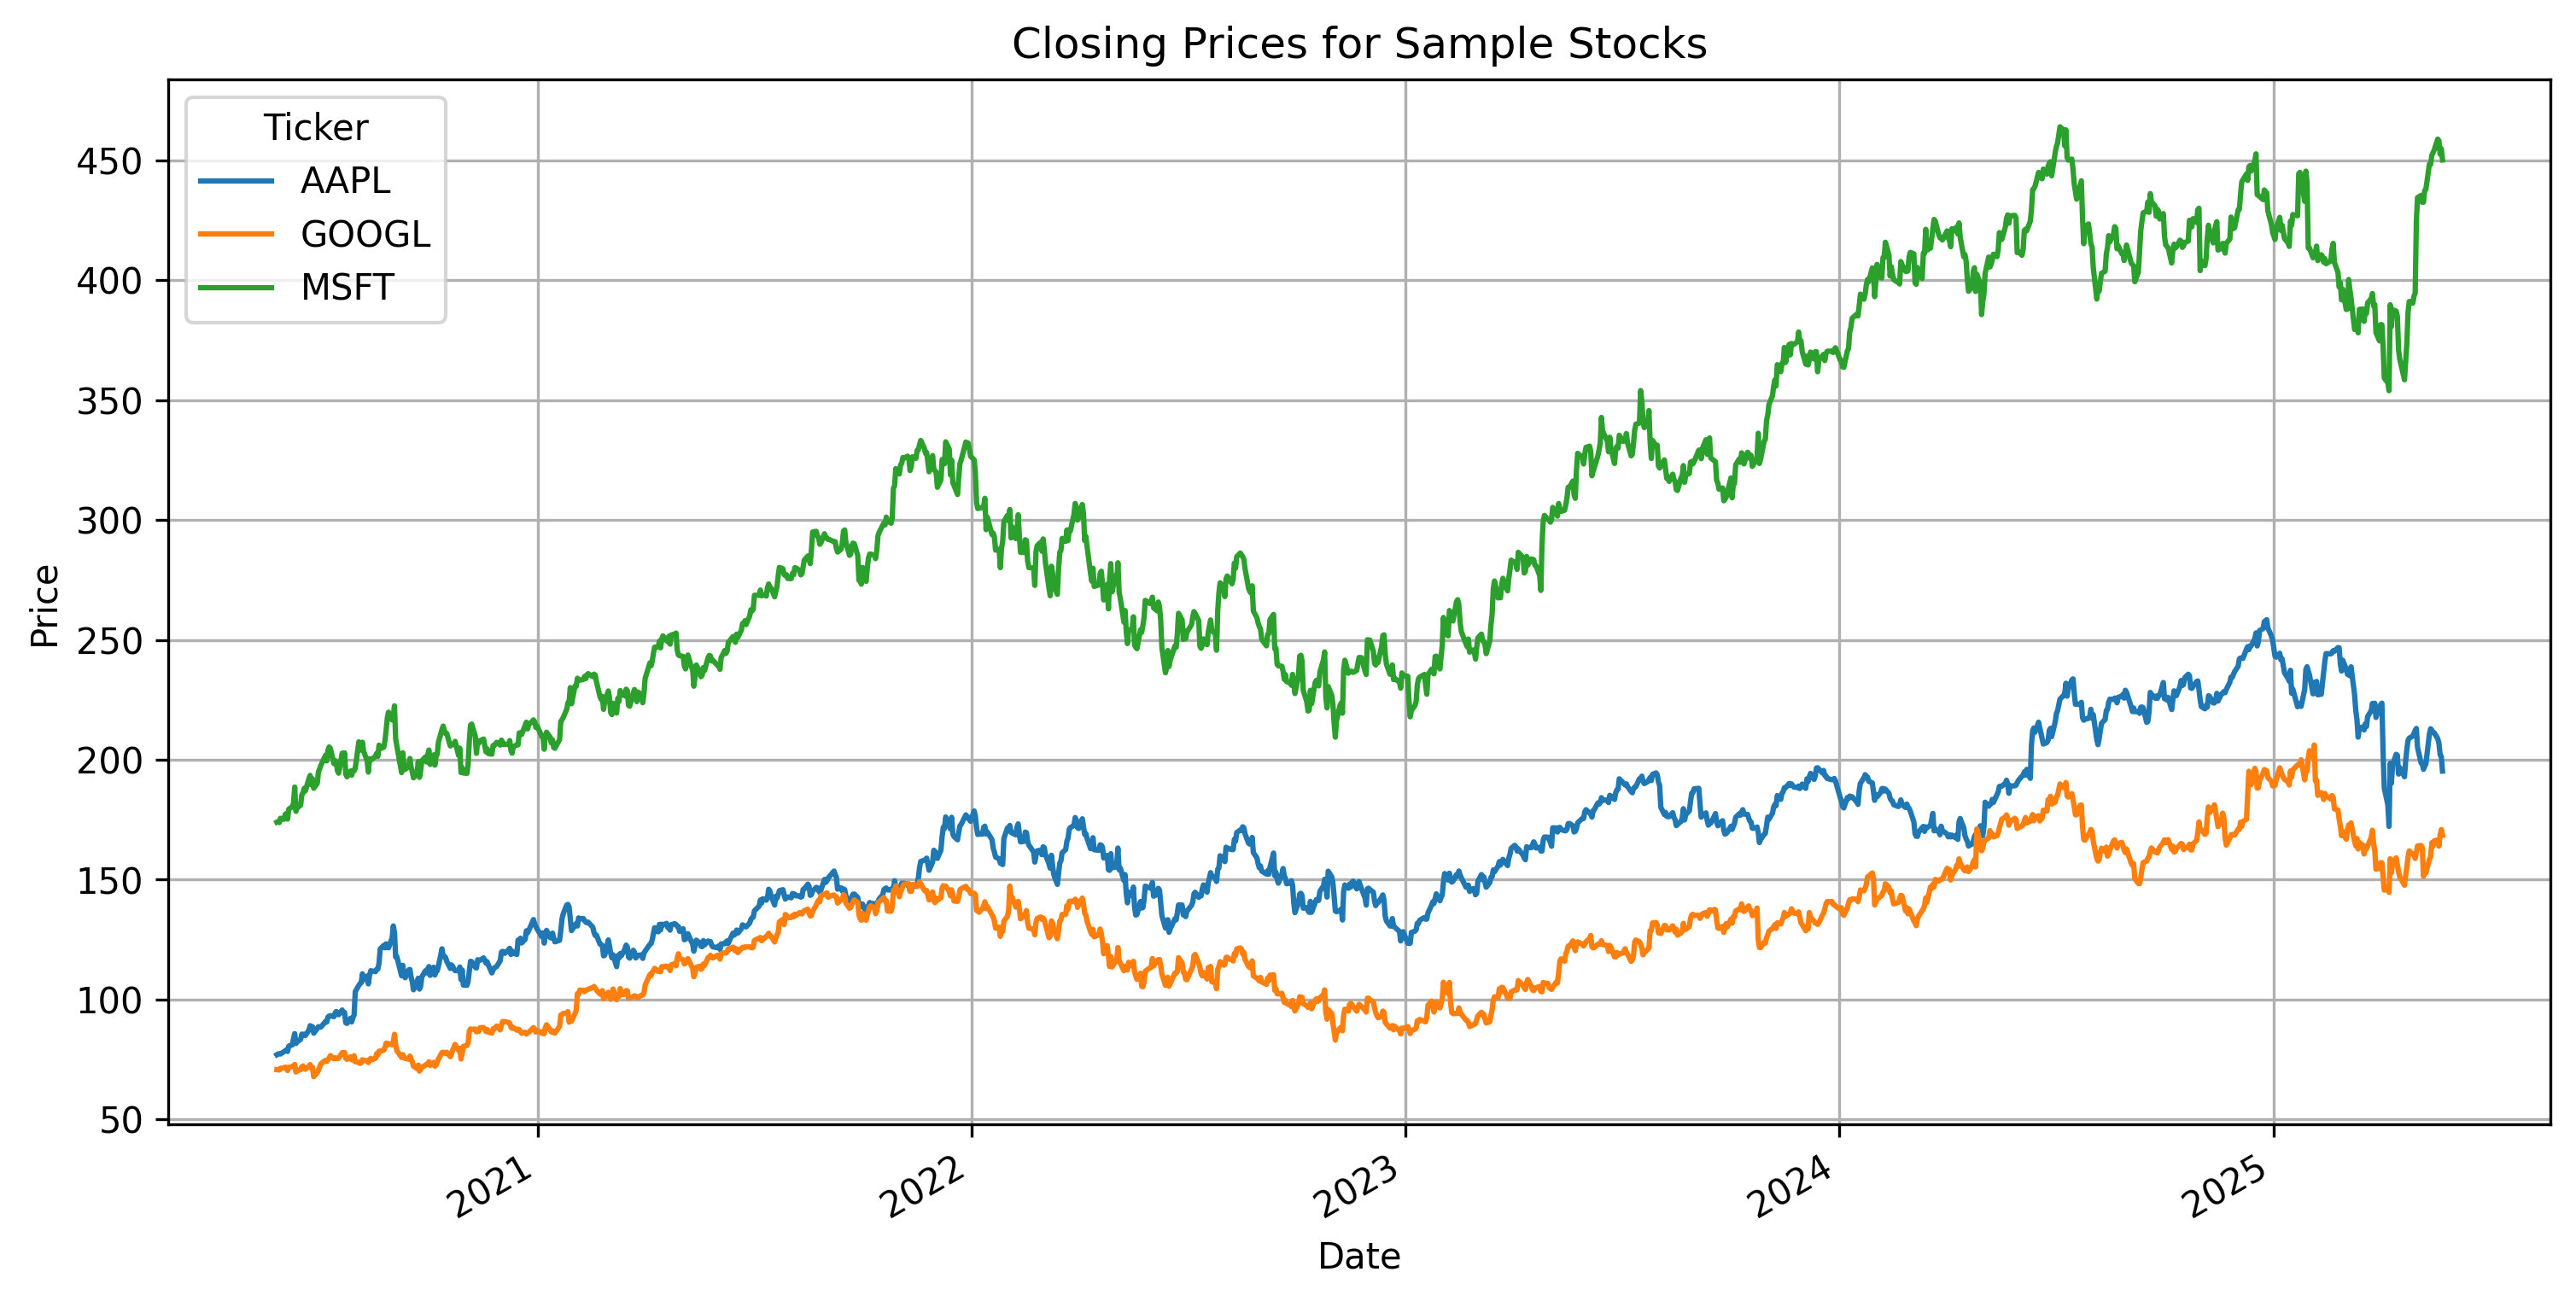

In [3]:
# Brief plot of closing prices for selected stocks over the given time period
fig, ax = plt.subplots(figsize = (12, 6), dpi = 300)
df.Close.plot(ax = ax)
ax.set_title("Closing Prices for Sample Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
plt.show()

## Step 2: Feature Engineering and Selection

From our existing features from our data, we can further create new features and our target variable to classify whether the stock price increased. For each time period $t$:

|**No.** |**New Feature**                  |**Variable Name**     |**Formula ($t$: Current time period)**                                                                                    |**Reason for creation**                                                                |
|:------:|:-------------------------------:|:-------------------: |:------------------------------------------------------------------------------------------------------------------------:|---------------------------------------------------------------------------------------|
| 1      | **Return**                      | `return`             | $\frac{\text{Close}_t - \text{Close}_{t-1}}{\text{Close}_{t-1}}$                                                         | Stationary, core signal                                                               |
| 2      | **Volume Change**               | `delta_volume`       | $\frac{\text{Volume}_t - \text{Volume}_{t-1}}{\text{Volume}_{t-1}}$                                                      | Momentum in investor attention                                                        |
| 3      | **Range Change**                | `delta_range`        | $\frac{(\text{High}_t - \text{Low}_t) - (\text{High}_{t-1} - \text{Low}_{t-1})}{\text{High}_{t-1} - \text{Low}_{t-1}}$   | Captures volatility expansion/contraction                                             |
| 4      | **Open-Close Gap**              | `delta_overnight`    | $\frac{\text{Open}_t - \text{Close}_{t-1}}{\text{Close}_{t-1}}$                                                          | Overnight effect                                                                      |
| 5      | **Close vs Open**               | `delta_intraday`     | $\frac{\text{Close}_t - \text{Open}_t}{\text{Open}_t}$                                                                   | Intraday return                                                                       |
| 6      | **Change in High**              | `delta_high`         | $\frac{\text{High}_t - \text{High}_{t-1}}{\text{High}_{t-1}}$                                                            | Measures upward price pressure                                                        |
| 7      | **Change in Low**               | `delta_low`          | $\frac{\text{Low}_t - \text{Low}_{t-1}}{\text{Low}_{t-1}}$                                                               | Measures downward price pressure                                                      |
| 8      | **Change in Open**              | `delta_open`         | $\frac{\text{Open}_t - \text{Open}_{t-1}}{\text{Open}_{t-1}}$                                                            | Captures shifts in opening sentiment                                                  |
| 9      | **Avg. Return (5d)**            | `avg_return_5d`      | $\frac{\text{Return}_{t-4} + \ldots + \text{Return}_t}{5}$                                                               | Short-term momentum (~1 week)                                                         |
|10      | **Avg. Return (20d)**           | `avg_return_20d`     | $\frac{\text{Return}_{t-19} + \ldots + \text{Return}_t}{20}$                                                             | Medium-term trend (~1 month)                                                          |
|11      | **Avg. Return (60d)**           | `avg_return_60d`     | $\frac{\text{Return}_{t-59} + \ldots + \text{Return}_t}{60}$                                                             | Long-term trend (~3 months)                                                           |
|12      | **Avg. StdDev (5d)**            | `avg_std_5d`         | $\text{Std}\left(\text{Return}_{t-4}, \ldots, \text{Return}_t\right)$                                                    | Short-term risk measure                                                               |
|13      | **Avg. StdDev (20d)**           | `avg_std_20d`        | $\text{Std}\left(\text{Return}_{t-19}, \ldots, \text{Return}_t\right)$                                                   | Medium-term risk                                                                      |
|14      | **Avg. StdDev (60d)**           | `avg_std_60d`        | $\text{Std}\left(\text{Return}_{t-59}, \ldots, \text{Return}_t\right)$                                                   | Long-term risk                                                                        |
|15      | **Avg. Volume (5d)**            | `avg_volume_5d`      | $\frac{\text{Volume Change}_{t-4} + \ldots + \text{Volume Change}_t}{5}$                                                 | Short-term attention trend                                                            |
|16      | **Avg. Volume (20d)**           | `avg_volume_20d`     | $\frac{\text{Volume Change}_{t-19} + \ldots + \text{Volume Change}_t}{20}$                                               | Medium-term attention                                                                 |
|17      | **Avg. Volume (60d)**           | `avg_volume_60d`     | $\frac{\text{Volume Change}_{t-59} + \ldots + \text{Volume Change}_t}{60}$                                               | Long-term attention                                                                   |
|18      | **Avg. Range (5d)**             | `avg_range_5d`       | $\frac{1}{5}\sum_{i = 0}^{4}\frac{\text{High}_{t-i} - \text{Low}_{t-i}}{\text{Close}_{t-i}}$                             | Short-term volatility                                                                 |
|19      | **Avg. Range (20d)**            | `avg_range_20d`      | $\frac{1}{20}\sum_{i = 0}^{19}\frac{\text{High}_{t-i} - \text{Low}_{t-i}}{\text{Close}_{t-i}}$                           | Medium-term volatility                                                                |
|20      | **Avg. Range (60d)**            | `avg_range_60d`      | $\frac{1}{60}\sum_{i = 0}^{59}\frac{\text{High}_{t-i} - \text{Low}_{t-i}}{\text{Close}_{t-i}}$                           | Long-term volatility                                                                  |
|21      | **Price to Avg. Return (5d)**   | `price_to_ma_5d`     | $\frac{\text{Close}_t}{\text{Avg. Return (5d)}_t} - 1$                                                                   | Short-term trend indicator                                                            |
|22      | **Price to Avg. Return (20d)**  | `price_to_ma_20d`    | $\frac{\text{Close}_t}{\text{Avg. Return (20d)}_t} - 1$                                                                  | Medium-term trend indicator                                                           |
|23      | **Price to Avg. Return (60d)**  | `price_to_ma_60d`    | $\frac{\text{Close}_t}{\text{Avg. Return (60d)}_t} - 1$                                                                  | Long-term trend indicator                                                             |
|24      | **Price Location (5d)**         | `price_location_5d`  | $\frac{\text{Close}_t - \min(\text{Low}_{t-4:t})}{\max(\text{High}_{t-4:t}) - \min(\text{Low}_{t-4:t})}$                 | Short-term oscillator                                                                 |
|25      | **Price Location (20d)**        | `price_location_20d` | $\frac{\text{Close}_t - \min(\text{Low}_{t-19:t})}{\max(\text{High}_{t-19:t}) - \min(\text{Low}_{t-19:t})}$              | Medium-term oscillator                                                                |
|26      | **Price Location (60d)**        | `price_location_60d` | $\frac{\text{Close}_t - \min(\text{Low}_{t-59:t})}{\max(\text{High}_{t-59:t}) - \min(\text{Low}_{t-59:t})}$              | Long-term oscillator                                                                  |
|27      | **Target**                      | `Target`             | $\text{Target} = \begin{cases} 1 & \text{if } \text{Close}_{t+1} > \text{Close}_{t} \\ 0 & \text{otherwise} \end{cases}$ | Binary Classification Target: 1 if next trading day has positive returns, 0 otherwise|

The new features can be grouped into 4 main categories:

1. **Momentum** (e.g. 5-day returns)
2. **Volatility** (e.g. 60-day rolling standard deviation)
3. **Market sentiment** (e.g. intraday returns)
4. **Price positioning** (e.g. 20-day price location oscillator)

The target variable (Target) is a binary label indicating whether the next day's closing price increased (1) or decreased (0). All features (apart from `return`) are normalized using `StandardScaler` for better numerical stability. Afterwards, we will choose the $n$ features most correlated with the target variable (`Target`) to use as inputs to the LSTM model, and adjust the input dimensions for the model accordingly.

In [4]:
# Enhanced features for stock price prediction LSTM
def create_enhanced_features(df, tickers, normalize = False):
    """
    Create enhanced features for multi-stock LSTM
    
    Parameters:
    -----------
    df : pandas.DataFrame
        MultiIndex DataFrame with (feature, ticker) structure
    tickers : list
        List of stock tickers
    normalize : bool
        Whether to normalize features globally
        
    Returns:
    --------
    df_features : pandas.DataFrame
        DataFrame with enhanced features
    scalers : dict
        Dictionary of scalers (if normalize = True)
    """
    scalers = {}
    
    # Collect all features in a dictionary first to avoid fragmentation
    all_features = {}
    
    # 1. EXISTING CORE FEATURES FROM YOUR TABLE
    for ticker in tickers:
        # Return (daily) 
        all_features[("return", ticker)] = df[("Close", ticker)].pct_change(fill_method = None)
        
        # Volume change
        all_features[("delta_volume", ticker)] = df[("Volume", ticker)].pct_change(fill_method = None)
        
        # Change in range
        current_range = df[("High", ticker)] - df[("Low", ticker)]
        prev_range = current_range.shift(1)
        all_features[("delta_range", ticker)] = (current_range - prev_range) / prev_range
        
        # Open-Close gap (overnight)
        all_features[("delta_overnight", ticker)] = (df[("Open", ticker)] - df[("Close", ticker)].shift(1)) / df[("Close", ticker)].shift(1)
        
        # Close vs Open (intraday return)
        all_features[("delta_intraday", ticker)] = (df[("Close", ticker)] - df[("Open", ticker)]) / df[("Open", ticker)]
        
        # % Change in High
        all_features[("delta_high", ticker)] = df[("High", ticker)].pct_change(fill_method = None)
        
        # % Change in Low
        all_features[("delta_low", ticker)] = df[("Low", ticker)].pct_change(fill_method = None)
        
        # % Change in Open
        all_features[("delta_open", ticker)] = df[("Open", ticker)].pct_change(fill_method = None)
    
    # 2. ROLLING WINDOW FEATURES
    # Optimal window sizes based on research and empirical evidence
    # Short (5): Captures recent momentum/trend
    # Medium (20): Captures intermediate trend (~1 month of trading)
    # Long (60): Captures longer-term trend (~3 months)
    windows = [5, 20, 60]
    
    for ticker in tickers:
        # Calculate returns first (avoid lookahead bias)
        returns = all_features[("return", ticker)]
        
        for window in windows:
            # Rolling mean of returns (momentum)
            all_features[(f"avg_return_{window}d", ticker)] = returns.rolling(window = window).mean()
            
            # Rolling std of returns (volatility)
            all_features[(f"avg_std_{window}d", ticker)] = returns.rolling(window = window).std()
            
            # Rolling mean of volume changes
            all_features[(f"avg_volume_{window}d", ticker)] = all_features[("delta_volume", ticker)].rolling(window = window).mean()
            
            # Rolling mean of trading range
            range_pct = (df[("High", ticker)] - df[("Low", ticker)]) / df[("Close", ticker)]
            all_features[(f"avg_range_{window}d", ticker)] = range_pct.rolling(window = window).mean()
            
            # Price relative to its moving averages
            ma = df[("Close", ticker)].rolling(window = window).mean()
            all_features[(f"price_to_ma_{window}d", ticker)] = df[("Close", ticker)] / ma - 1
            
            # Oscillator: price location within range 
            # (normalized price position between highest high and lowest low in window)
            high_window = df[("High", ticker)].rolling(window = window).max()
            low_window = df[("Low", ticker)].rolling(window = window).min()
            all_features[(f"price_location_{window}d", ticker)] = (df[("Close", ticker)] - low_window) / (high_window - low_window)
    
    # Create DataFrame from all features at once
    df_features = pd.DataFrame(all_features, index = df.index)
    
    # Drop NaN values (from rolling windows and pct_change)
    df_features = df_features.dropna()
    
    # Target: whether next close is higher (1) or not (0)
    target_features = {}
    for ticker in tickers:
        target_features[("Target", ticker)] = (df[("Close", ticker)].shift(-1) > df[("Close", ticker)]).astype(int)
    
    # Add targets to the DataFrame
    target_df = pd.DataFrame(target_features, index = df.index)
    df_features = pd.concat([df_features, target_df.loc[df_features.index]], axis = 1)
    
    # Drop the last row (has NaN target)
    df_features = df_features.dropna()
    
    # 3. NORMALIZATION OF FEATURES
    # Normalize features if requested (recommended for numerical stability)
    if normalize:
        # Group features by type to scale them together across tickers
        feature_types = set([col[0] for col in df_features.columns if col[0] != "Target"])
        
        for feature in feature_types:
            # Get all columns for this feature type
            feature_cols = [(feature, ticker) for ticker in tickers if (feature, ticker) in df_features.columns]
            
            # Skip if no columns exist for this feature (fixes the error)
            if not feature_cols:
                continue
                
            # Collect this feature for all tickers
            feature_arrays = []
            for ticker in tickers:
                if (feature, ticker) in df_features.columns:
                    feature_arrays.append(df_features[(feature, ticker)].values.reshape(-1, 1))
            
            # Skip if no arrays to concatenate
            if not feature_arrays:
                continue
                
            # Concatenate arrays
            feature_data = np.concatenate(feature_arrays)

            # Replace infs with NaN and fill with column mean
            feature_data = np.where(np.isfinite(feature_data), feature_data, np.nan)

            if np.isnan(feature_data).any():
                col_means = np.nanmean(feature_data, axis = 0)
                inds = np.where(np.isnan(feature_data))
                feature_data[inds] = np.take(col_means, inds[1])
                print(f"Ticker Name: {ticker}")
                print(f"[Warning] Filled NaNs in feature '{feature}' with column means during normalization.")

            # Fit scaler safely
            scaler = StandardScaler().fit(feature_data)
            scalers[feature] = scaler

            # Apply scaling
            for ticker in tickers:
                if (feature, ticker) in df_features.columns and feature != "return":
                    vals = df_features[(feature, ticker)].values.reshape(-1, 1)
                    vals = np.where(np.isfinite(vals), vals, np.nan)
                    if np.isnan(vals).any():
                        col_mean = np.nanmean(vals)
                        vals = np.nan_to_num(vals, nan = col_mean)
                    df_features[(feature, ticker)] = scaler.transform(vals).flatten()
                    
    return df_features, scalers

# Function to select the most important features
def select_important_features(df_features, tickers, max_features_per_ticker = 10):
    """
    Select most important features based on correlation with target
    
    Parameters:
    -----------
    df_features : pandas.DataFrame
        DataFrame with all features
    tickers : list
        List of stock tickers
    max_features_per_ticker : int
        Maximum number of features to select per ticker

    Returns:
    --------
    selected_features : dict
        Dictionary of selected features by ticker
    """
    selected_features = {}
    
    for ticker in tickers:
        # Get all features for this ticker except Target
        ticker_features = [col for col in df_features.columns 
                         if col[1] == ticker and col[0] != "Target"]
        
        # Calculate correlation with target
        correlations = {}
        target = df_features[("Target", ticker)]
        
        for feature in ticker_features:
            # Calculate absolute correlation
            corr = abs(df_features[feature].corr(target))
            correlations[feature] = corr
        
        # Sort by absolute correlation (descending)
        sorted_features = sorted(correlations.items(), key = lambda x: x[1], reverse = True)
        
        # Select top features
        selected = [feature for feature, corr in sorted_features[:max_features_per_ticker]]
        selected_features[ticker] = selected
    
    return selected_features


## Step 3: Model Preparation and Architecture

The `prepare_lstm_data` function takes historical feature and target data for a specific stock ticker and formats it into a structure suitable for LSTM models. It constructs rolling sequences of a specified length, each representing a window of time used as input to predict whether the stock price will go up or down on the final day of that window. This temporal framing is crucial for capturing sequential patterns in financial time series data.

The `EnhancedDirectionPredictionModel` defines the LSTM-based neural network architecture used for directional prediction of stock prices. It consists of an LSTM backbone with optional dropout and attention mechanisms, followed by two fully connected layers with leaky ReLU activation to avoid the vanishing gradient porblem. The final output is a softmax probability over two classes: "up" and "down." This model is designed to be flexible and robust, with support for multiple LSTM layers and dropout regularization to mitigate overfitting.

To train the model, the `train_lstm_model` function implements a training loop with early stopping based on validation loss. It uses the cross-entropy loss function and the Adam optimizer and tracks the model's performance over epochs. Training and validation accuracy and loss are stored for later visualization and diagnostics, ensuring the model generalizes well without overfitting to the training data.

The `evaluate_model` function handles performance evaluation on test data. It calculates accuracy, precision for upward predictions, and applies a probability threshold to determine whether the model predicts an upward price movement. It also collects model outputs, true labels, and probabilities for deeper analysis and plotting.

Finally, the `run_lstm_pipeline` function orchestrates the full modeling pipeline. For each stock ticker, it selects important features, prepares LSTM sequences, splits the data into training, validation, and test sets, trains the model, evaluates its performance, and visualizes results. It also computes the model's average return from trading decisions and compares it to the theoretical maximum return, offering a quantitative benchmark of how profitable the model could be in practice.

In [5]:
# Function to prepare sequences for LSTM
def prepare_lstm_data(df_features, ticker, feature_list, target_col, seq_length = 30):
    """
    Prepare data sequences for LSTM training/testing
    
    Parameters:
    -----------
    df_features : pandas.DataFrame
        DataFrame with all features
    ticker : str
        Stock ticker to prepare data for
    feature_list : list
        List of features to use
    target_col : tuple
        Column name for target (e.g., ("Target", "AAPL"))
    seq_length : int
        Sequence length for LSTM
        
    Returns:
    --------
    X : numpy.ndarray
        Input sequences for LSTM
    y : numpy.ndarray
        Target values
    """
    # Extract feature columns and target
    features_data = df_features[feature_list].values
    target_data = df_features[target_col].values
    
    data = []
    targets = []
    
    # Create sequences
    for i in range(len(df_features) - seq_length):
        sequence = features_data[i:i+seq_length]  # shape: (seq_length, num_features)
        target = target_data[i+seq_length-1]  # The target for the last timestep
        data.append(sequence)
        targets.append(target)
    
    X = np.array(data)  # shape: (samples, seq_length, num_features)
    y = np.array(targets)  # shape: (samples,)
    
    return X, y

# Enhanced LSTM model for stock price direction prediction
class EnhancedDirectionPredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers = 1, dropout = 0.3, output_dim = 2):
        super(EnhancedDirectionPredictionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers with dropout
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first = True, 
            dropout = dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Attention mechanism (optional)
        self.attention = nn.Linear(hidden_dim, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Activation functions
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out: (batch_size, seq_length, hidden_dim)
        
        # Attention mechanism (optional)
        attention_weights = torch.softmax(self.attention(lstm_out), dim = 1)
        context_vector = torch.sum(attention_weights * lstm_out, dim = 1)
        
        # Or simply use the last hidden state
        last_hidden = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # Apply dropout
        out = self.dropout(last_hidden)
        
        # Apply fully connected layers with activation
        out = self.leaky_relu(self.fc1(out))
        out = self.dropout(out)
        logits = self.fc2(out)
        
        # Apply softmax to get probabilities
        probs = self.softmax(logits)
        
        return probs

# Function to train LSTM model with early stopping
def train_lstm_model(model, X_train, y_train, X_val, y_val, lr = 0.001, batch_size = 32, num_epochs = 200, patience = 30):
    """
    Train LSTM model with early stopping
    
    Parameters:
    -----------
    model : nn.Module
        PyTorch model
    X_train, y_train : torch.Tensor
        Training data
    X_val, y_val : torch.Tensor
        Validation data
    lr : float
        Learning rate
    batch_size : int
        Batch size
    num_epochs : int
        Maximum number of epochs
    patience : int
        Early stopping patience
        
    Returns:
    --------
    model : nn.Module
        Trained model
    history : dict
        Training history
    """
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    # Initialize variables for early stopping
    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0
    
    # Track history
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_acc = (val_predicted == y_val).sum().item() / len(y_val)
        
        # Store history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - "
                  f"Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

# Function to evaluate model and generate trading metrics
def evaluate_model(model, X_test, y_test, threshold = 0.5):
    """
    Evaluate trained model and generate trading metrics
    
    Parameters:
    -----------
    model : nn.Module
        Trained PyTorch model
    X_test, y_test : torch.Tensor
        Test data
    threshold : float
        Probability threshold for classifying 'Up' (class 1)
        
    Returns:
    --------
    metrics : dict
        Evaluation metrics
    """
    model.eval()
    with torch.no_grad():
        # Get predicted probabilities
        test_outputs = model(X_test)  # shape: (n_samples, 2)
        test_probs = test_outputs.cpu().numpy()
        y_test_np = y_test.cpu().numpy()
        
        # Apply threshold to "Up" class probabilities
        up_probs = test_probs[:, 1]
        test_pred_np = (up_probs >= threshold).astype(int)

        # Calculate accuracy
        accuracy = (test_pred_np == y_test_np).sum() / len(y_test_np)

        # Calculate precision for "Up" predictions
        if (test_pred_np == 1).sum() > 0:
            precision_up = ((test_pred_np == 1) & (y_test_np == 1)).sum() / (test_pred_np == 1).sum()
        else:
            precision_up = 0.0

    metrics = {
        "accuracy": accuracy,
        "precision_up": precision_up,
        "predictions": test_pred_np,
        "probabilities": up_probs,
        "y_true": y_test_np,
        "threshold": threshold
    }
    
    return metrics

# Main function to run the enhanced LSTM pipeline
def run_lstm_pipeline(df, tickers, seq_length = 30, hidden_dim = 64, num_layers = 2, max_features = 10, train_ratio = 0.8, batch_size = 32, lr = 0.001):
    """
    Run the complete LSTM pipeline for stock price direction prediction
    
    Parameters:
    -----------
    df : pandas.DataFrame
        MultiIndex DataFrame with stock data from Yahoo Finance API
    tickers : list
        List of stock tickers
    seq_length : int
        Sequence length for LSTM
    hidden_dim : int
        Hidden dimension for LSTM
    num_layers : int
        Number of LSTM layers
    max_features : int
        Maximum number of features to use per ticker
    train_ratio : float
        Ratio for train/test split
    batch_size : int
        Batch size for training
    lr : float
        Learning rate for optimizer
        
    Returns:
    --------
    results : dict
        Results for each ticker
    """
    results = {}
    
    # Create enhanced features
    print("Creating enhanced features...")
    df_features, scalers = create_enhanced_features(df, tickers, normalize = True)
    
    # Process each ticker
    for ticker in tickers:
        print(f"\nProcessing ticker: {ticker}")
        
        # Select important features
        selected_features = select_important_features(df_features, [ticker], max_features_per_ticker = max_features)
        ticker_features = selected_features[ticker]
        print(f"Selected {len(ticker_features)} features: {ticker_features}")
        
        # Prepare sequences for LSTM
        target_col = ("Target", ticker)
        X, y = prepare_lstm_data(df_features, ticker, ticker_features, target_col, seq_length)
        
        # Train/validation/test split
        train_size = int(train_ratio * len(X))
        val_size = int(0.1 * len(X))  # 10% for validation
        
        X_train = torch.from_numpy(X[:train_size]).float().to(device)
        y_train = torch.from_numpy(y[:train_size]).long().to(device)
        
        X_val = torch.from_numpy(X[train_size:train_size+val_size]).float().to(device)
        y_val = torch.from_numpy(y[train_size:train_size+val_size]).long().to(device)
        
        X_test = torch.from_numpy(X[train_size+val_size:]).float().to(device)
        y_test = torch.from_numpy(y[train_size+val_size:]).long().to(device)
        
        print(f"Data shapes - X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
        
        # Initialize and train model
        input_dim = len(ticker_features)
        model = EnhancedDirectionPredictionModel(
            input_dim = input_dim,
            hidden_dim = hidden_dim,
            num_layers = num_layers,
            dropout = 0.2
        ).to(device)
        
        print("Training model...")
        model, history = train_lstm_model(
            model, X_train, y_train, X_val, y_val,
            lr = lr, batch_size = batch_size, num_epochs = 200, patience = 20
        )
        
        # Evaluate model
        print("Evaluating model...")
        threshold_up = 0.65 # Select threshold for probability to be classified as positive (i.e. next day positive return)
        metrics = evaluate_model(model, X_test, y_test, threshold = threshold_up)

        # Get the expected return from trading based on future prediction 1 day in advance
        test_start_idx = train_size + val_size + seq_length - 1 # Starting index of the test set
        next_day_returns = df_features[("return", ticker)][test_start_idx+1:test_start_idx+1+len(metrics["predictions"])]  # Shift the returns to align with predictions (next day's return)
        model_avg_return = (metrics["predictions"] * next_day_returns).mean() # Calculate model average return using next day"s returns (Only reap the extra returns on the next day)
        max_avg_return = (metrics["y_true"] * next_day_returns).mean() # Calculate theoretical maximum average return
        
        # Store results
        results[ticker] = {
            "model": model,
            "model_avg_return": model_avg_return,
            "max_avg_return": max_avg_return,
            "history": history,
            "metrics": metrics,
            "selected_features": ticker_features
        }
        
        # Print evaluation metrics
        print(f"\nTest Accuracy: {metrics['accuracy']:.4f}")
        print(f"Test Precision: {metrics['precision_up']:.4f} (Model predicts price going up correctly {metrics['precision_up']*100:.2f}% of the time)") # TP / (TP+FP)
        print(f"Model Average Return: {model_avg_return*100:.4f}%")
        print(f"Optimal Average Return: {max_avg_return*100:.4f}%")
        
        # Generate classification report
        print("\nClassification Report (Test Set):")
        print(classification_report(metrics["y_true"], metrics["predictions"]))

        # Create figure with 3 subplots (1 row, 3 columns)
        fig, axes = plt.subplots(1, 3, figsize = (15, 5), dpi = 300)
        
        # 1st subplot - Initial confusion matrix
        cm = confusion_matrix(metrics["y_true"], metrics["predictions"])
        cmp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Down", "Up"])
        cmp.plot(ax = axes[0], cmap = "Blues")
        axes[0].set_title(f"Confusion Matrix - {ticker} \nZ = {threshold_up:.4f}")

        # 2nd subplot - Loss
        axes[1].plot(history["train_loss"], label = "Train")
        axes[1].plot(history["val_loss"], label = "Validation")
        axes[1].set_title("Training VS Validation Set Loss")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()

        # 3rd subplot - Accuracy
        axes[2].plot(history["train_acc"], label = "Train")
        axes[2].plot(history["val_acc"], label = "Validation")
        axes[2].set_title("Training VS Validation Set Accuracy")
        axes[2].set_xlabel("Epoch")
        axes[2].set_ylabel("Accuracy")
        axes[2].legend()

        # Add a super title
        fig.suptitle(f"Test Performance results on {ticker}", fontsize = 14, fontweight = "bold")

        # Adjust layout
        plt.tight_layout()
        plt.show()

    return results


## Step 4: Choose stocks and run the model

The `run_lstm_pipeline` function trains and evaluates an LSTM model for each selected ticker (e.g., AAPL, MSFT, GOOGL). It processes multi-index stock data by selecting up to 8 key features per ticker, generating 30-day sequences, and splitting the data into training, validation, and test sets.

A 3-layer LSTM with 32 hidden units is trained per ticker, with early stopping based on validation loss. The function returns prediction accuracy and return-based metrics, allowing users to assess both model performance and investment relevance in a single step.

Creating enhanced features...

Processing ticker: AAPL
Selected 10 features: [('delta_range', 'AAPL'), ('avg_std_5d', 'AAPL'), ('avg_return_60d', 'AAPL'), ('avg_return_20d', 'AAPL'), ('price_to_ma_60d', 'AAPL'), ('avg_return_5d', 'AAPL'), ('avg_volume_20d', 'AAPL'), ('price_location_60d', 'AAPL'), ('avg_volume_60d', 'AAPL'), ('price_to_ma_20d', 'AAPL')]
Data shapes - X_train: torch.Size([933, 30, 10]), X_val: torch.Size([116, 30, 10]), X_test: torch.Size([118, 30, 10])
Training model...
Epoch 10/200 - Train Loss: 0.688680, Train Acc: 0.5263, Val Loss: 0.694326, Val Acc: 0.4655
Epoch 20/200 - Train Loss: 0.686118, Train Acc: 0.5359, Val Loss: 0.697887, Val Acc: 0.4569
Early stopping at epoch 21
Evaluating model...

Test Accuracy: 0.5593
Test Precision: 0.6176 (Model predicts price going up correctly 61.76% of the time)
Model Average Return: 0.0054%
Optimal Average Return: 0.7587%

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      

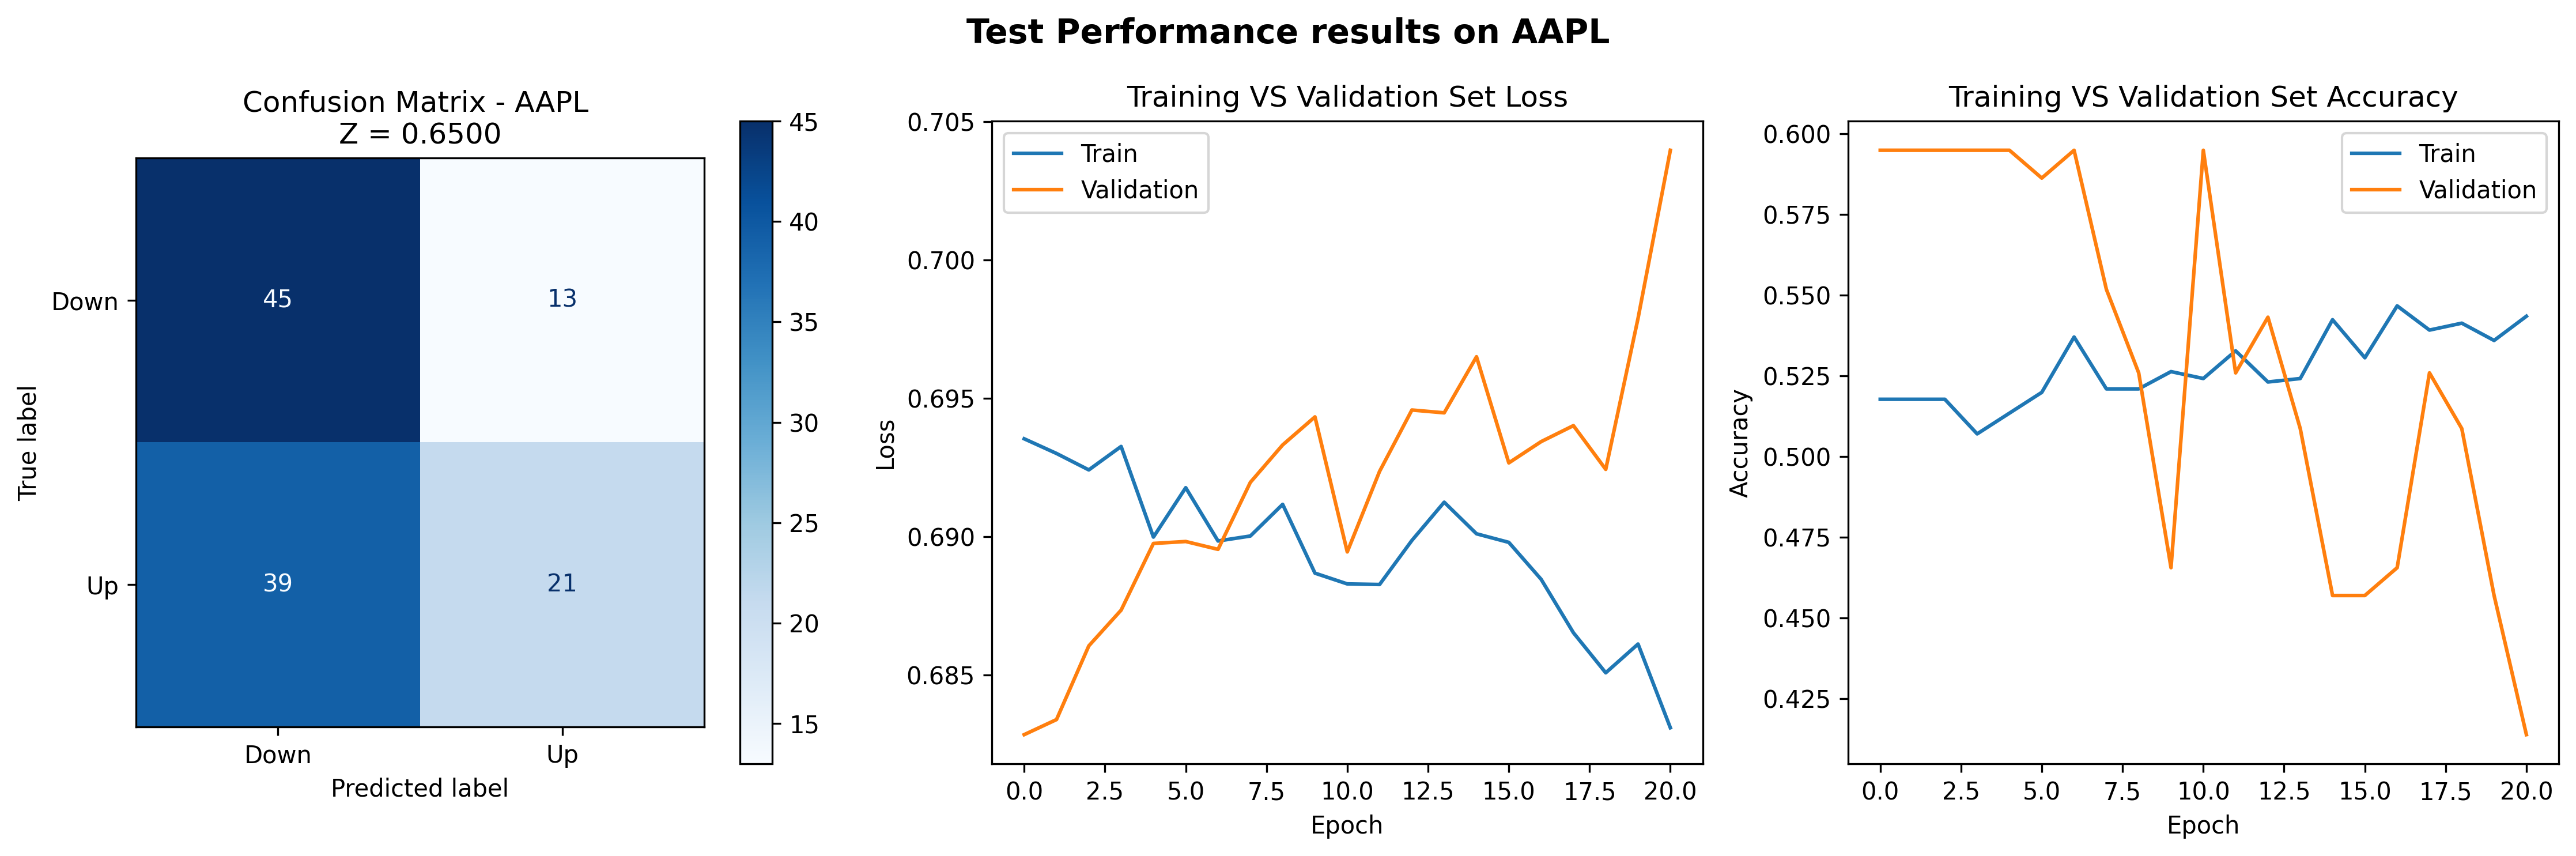


Processing ticker: MSFT
Selected 10 features: [('avg_return_20d', 'MSFT'), ('price_to_ma_60d', 'MSFT'), ('delta_overnight', 'MSFT'), ('price_location_20d', 'MSFT'), ('price_location_60d', 'MSFT'), ('price_to_ma_20d', 'MSFT'), ('avg_return_60d', 'MSFT'), ('delta_intraday', 'MSFT'), ('avg_std_60d', 'MSFT'), ('avg_range_60d', 'MSFT')]
Data shapes - X_train: torch.Size([933, 30, 10]), X_val: torch.Size([116, 30, 10]), X_test: torch.Size([118, 30, 10])
Training model...
Epoch 10/200 - Train Loss: 0.687217, Train Acc: 0.5477, Val Loss: 0.691035, Val Acc: 0.5431
Epoch 20/200 - Train Loss: 0.680530, Train Acc: 0.5638, Val Loss: 0.692069, Val Acc: 0.5431
Early stopping at epoch 28
Evaluating model...

Test Accuracy: 0.4746
Test Precision: 0.4928 (Model predicts price going up correctly 49.28% of the time)
Model Average Return: 0.0014%
Optimal Average Return: 0.6536%

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.45      0.39      

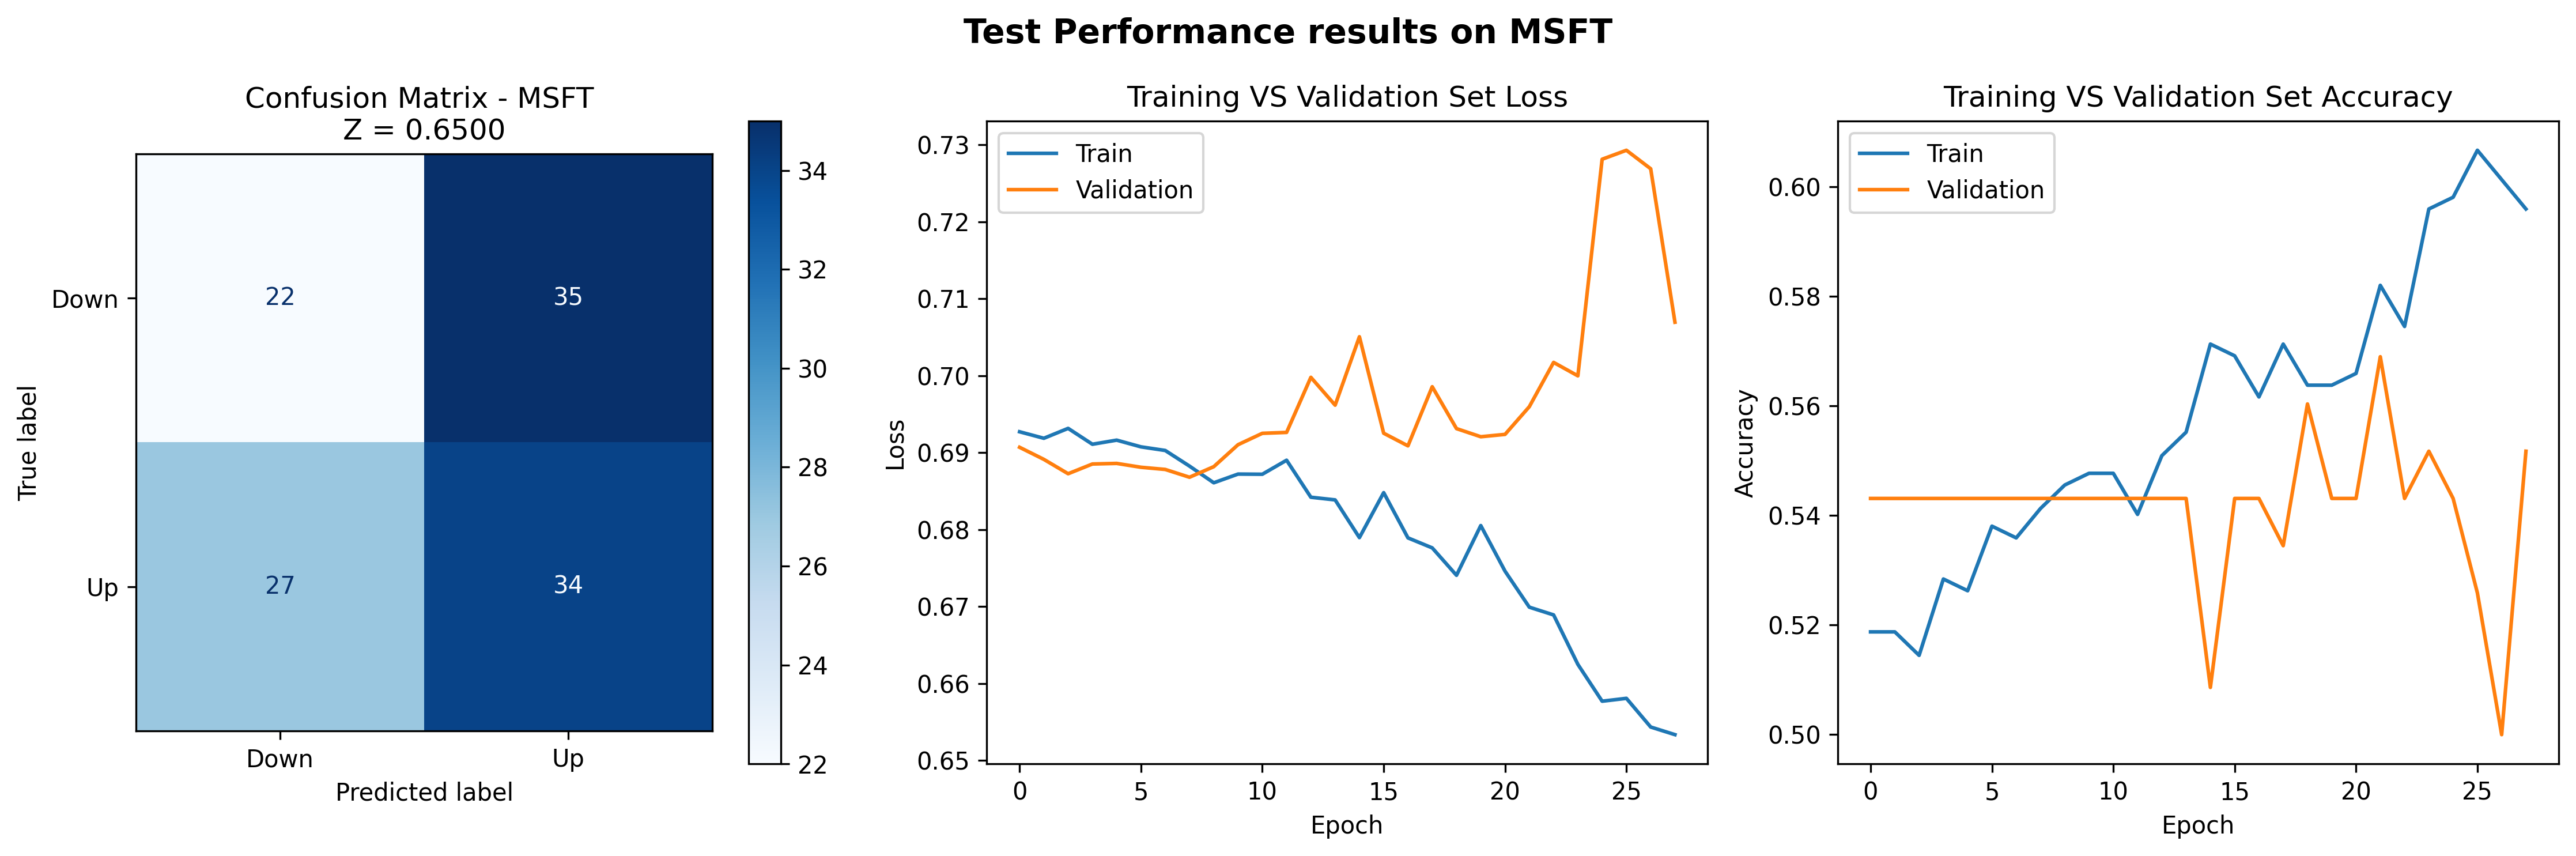


Processing ticker: GOOGL
Selected 10 features: [('avg_std_60d', 'GOOGL'), ('avg_return_5d', 'GOOGL'), ('avg_range_60d', 'GOOGL'), ('price_location_5d', 'GOOGL'), ('avg_std_20d', 'GOOGL'), ('price_to_ma_20d', 'GOOGL'), ('avg_return_20d', 'GOOGL'), ('price_to_ma_5d', 'GOOGL'), ('price_location_20d', 'GOOGL'), ('avg_range_20d', 'GOOGL')]
Data shapes - X_train: torch.Size([933, 30, 10]), X_val: torch.Size([116, 30, 10]), X_test: torch.Size([118, 30, 10])
Training model...
Epoch 10/200 - Train Loss: 0.683401, Train Acc: 0.5702, Val Loss: 0.686599, Val Acc: 0.5603
Epoch 20/200 - Train Loss: 0.674960, Train Acc: 0.5820, Val Loss: 0.688043, Val Acc: 0.5603
Epoch 30/200 - Train Loss: 0.658339, Train Acc: 0.6152, Val Loss: 0.685329, Val Acc: 0.5776
Epoch 40/200 - Train Loss: 0.646902, Train Acc: 0.6281, Val Loss: 0.689785, Val Acc: 0.5948
Epoch 50/200 - Train Loss: 0.632085, Train Acc: 0.6581, Val Loss: 0.709665, Val Acc: 0.5690
Early stopping at epoch 50
Evaluating model...

Test Accuracy: 0.5

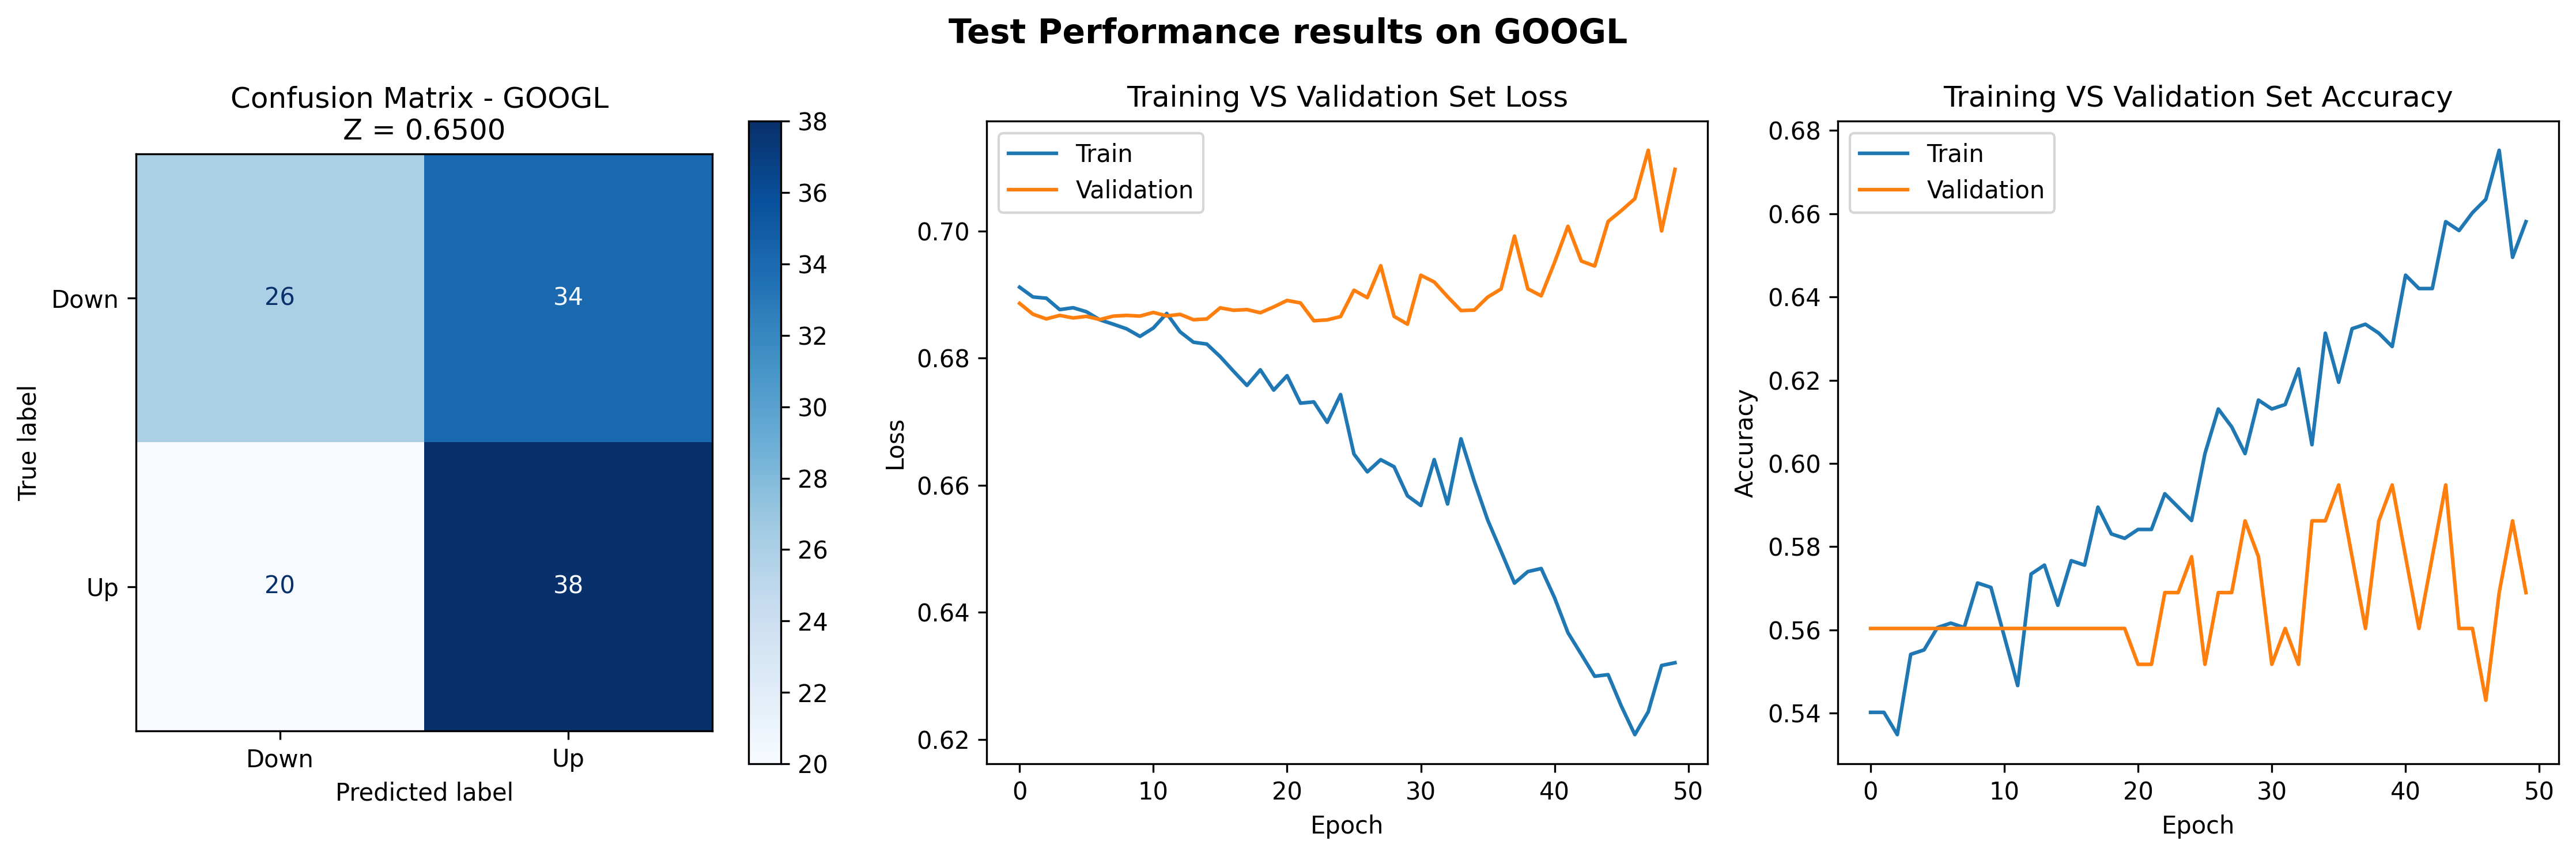

In [6]:
# Assuming df is your stock data with multiindex columns like:
# (Open, AAPL), (Close, AAPL), (High, AAPL), etc.
tickers = ["AAPL", "MSFT", "GOOGL"]  # Add more tickers if needed

results = run_lstm_pipeline(
    df = df, # Dataframe from yfinance API
    tickers = tickers, # Tickers to include (Same as df)
    seq_length = 30,  # Number of days in each sequence
    hidden_dim = 64,  # Size of hidden layer in LSTM
    num_layers = 3,   # Number of LSTM layers
    max_features = 10 # Max features to select per ticker
)

In [7]:
# Create list of records for DataFrame
records = []
for ticker, ticker_data in results.items():
    records.append({
        "Ticker": ticker,
        "model_avg_return": ticker_data["model_avg_return"],
        "max_avg_return": ticker_data["max_avg_return"],
        "model": str(ticker_data["model"]),  # Convert model object to string
        "model_selected_features": ticker_data["selected_features"],
        "threshold": ticker_data["metrics"]["threshold"],
        "accuracy": ticker_data["metrics"]["accuracy"],
        "precision": ticker_data["metrics"]["precision_up"]
    })

# Create DataFrame
results_df = pd.DataFrame(records)

# Reorder columns to match requested format
results_df = results_df[["Ticker", "model_avg_return", "max_avg_return","model", "model_selected_features", "threshold", "accuracy", "precision"]]
results_df

,Ticker,model_avg_return,max_avg_return,model,model_selected_features,threshold,accuracy,precision
0,AAPL,0.000054,0.007587,EnhancedDirectionPredictionModel(\n (lstm): L...,"[(delta_range, AAPL), (avg_std_5d, AAPL), (avg...",0.65,0.559322,0.617647
1,MSFT,0.000014,0.006536,EnhancedDirectionPredictionModel(\n (lstm): L...,"[(avg_return_20d, MSFT), (price_to_ma_60d, MSF...",0.65,0.474576,0.492754
2,GOOGL,0.001914,0.008938,EnhancedDirectionPredictionModel(\n (lstm): L...,"[(avg_std_60d, GOOGL), (avg_return_5d, GOOGL),...",0.65,0.542373,0.527778


### Compare LSTM model average return to completely random strategy

In [8]:
# Random seed for reproducability
np.random.seed(42)

# Example usage
test_set_idx = -118 # Use starting index from the test set
df_features, scalers = create_enhanced_features(df, tickers = tickers, normalize = True)
test_returns = df_features[[("return", t) for t in tickers]][test_set_idx:] 

for ticker in tickers:
    test_returns[("invest", ticker)] =  np.random.choice([0, 1], size = len(test_returns), p = [0.5, 0.5]) # Pick days in test set to invest at random
    test_returns[("day_return", ticker)] = test_returns[("return", ticker)] * test_returns[("invest", ticker)]

# Compute the average return across stocks per day
day_return_cols = test_returns.filter(like = "day_return", axis = 1)
day_return_cols.mean()

day_return  AAPL     0.000818
            MSFT     0.002106
            GOOGL    0.001579
dtype: float64

In [9]:
# Compare average returns against all selected stocks against a perfect model and a completely random model
print("* * * AVERAGE RETURNS FOR LSTM MODEL AGAINST BENCHMARKS FOR AAPL, GOOGL, MSFT * * *")
print(f"LSTM Model Average Return among all stocks   : {results_df['model_avg_return'].mean()*100:.4}%")
print(f"Maximum Average Return among all stocks      : {results_df['max_avg_return'].mean()*100:.4}%")
print(f"Random Model Average Return among 500 stocks : {day_return_cols.mean().mean()*100:.4}%")

* * * AVERAGE RETURNS FOR LSTM MODEL AGAINST BENCHMARKS FOR AAPL, GOOGL, MSFT * * *
LSTM Model Average Return among all stocks   : 0.06606%
Maximum Average Return among all stocks      : 0.7687%
Random Model Average Return among 500 stocks : 0.1501%


From our comparison with the random strategy, it becomes clear that the LSTM model does not always outperform a completely random baseline. While there are instances where it performs slightly better for the selected stocks (AAPL, MSFT, and GOOGL), this outcome is not guaranteed and may vary depending on the choice of model parameters or the random seed used during training and evaluation. The extreme variability in performance highlights the importance of caution when interpreting early results from a small subset of stocks.

## Step 5: Expand Scope of Model - Apply to all S&P 500 Stocks

So far, the model has been tested only on AAPL, MSFT, and GOOGL, which are three of the largest technology companies in the S&P 500 as of May 2025. While these examples provide an initial indication of performance, they do not offer a complete picture of the model's generalizability. In fact, the LSTM model does not consistently outperform a random strategy across these stocks, and its relative success may be influenced by factors such as the choice of model parameters or the random seed used.

To better understand the model's true potential, we now expand the analysis to include a much broader set of stocks across the S&P 500. By incorporating companies from different sectors and market capitalizations, we aim to evaluate whether the LSTM model can reliably detect temporal patterns in a wider range of market conditions. This broader evaluation is essential to assess the robustness and practical value of the model, and may also reveal whether it has consistent predictive power beyond a narrow group of large-cap tech stocks.

In [10]:
# Fastest way to get stocks in the S&P 500
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" # URL of the Wikipedia page
tables = pd.read_html(url) # Fetch all tables on the page
sp500_table = tables[0] # The first table contains S&P 500 constituents
sp500_table["Symbol"] = sp500_table["Symbol"].str.replace(".", "-", regex = False) # Replace "." with "-" in the Symbol column to correct format 
sp500_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [11]:
sp500_df = yf.download(sp500_table["Symbol"].tolist(), iso8601_5_yrs_ago) # Download all S&P 500 stock tickers and data from Yahoo Finance API
sp500_df.dropna(axis = 1, inplace = True) # Drop all tickers that do not have full past 5 years of data
sp500_df

[*********************100%***********************]  503 of 503 completed


Price            Close                                                 \
Ticker               A        AAPL        ABBV         ABT       ACGL   
Date                                                                    
2020-05-26   83.270195   76.970863   73.909958   81.892754  27.946907   
2020-05-27   83.318527   77.306213   73.315163   83.064194  28.450884   
2020-05-28   83.811592   77.340240   73.355904   84.290581  27.614094   
2020-05-29   85.213463   77.264908   75.506950   86.871475  26.834356   
2020-06-01   86.924713   78.215111   73.901794   85.123436  27.671148   
...                ...         ...         ...         ...        ...   
2025-05-19  113.440002  208.779999  185.710007  135.550003  95.160004   
2025-05-20  113.480003  206.860001  184.850006  135.199997  94.190002   
2025-05-21  108.910004  202.089996  181.800003  133.050003  92.849998   
2025-05-22  109.680000  201.360001  182.539993  131.500000  91.970001   
2025-05-23  108.529999  195.270004  183.259995  131.300003  92.070000   

Price                                                                  ...  \
Ticker             ACN        ADBE         ADI        ADM         ADP  ...   
Date                                                                   ...   
2020-05-26  182.336823  376.630005  102.967789  32.352299  125.067635  ...   
2020-05-27  185.614029  375.170013  104.776810  33.981682  130.244308  ...   
2020-05-28  187.229462  379.829987  101.929100  33.981682  130.361328  ...   
2020-05-29  187.182983  386.600006  103.757149  34.251797  131.882843  ...   
2020-06-01  188.817001  389.679993  103.600975  33.885834  131.036545  ...   
...                ...         ...         ...        ...         ...  ...   
2025-05-19  319.390015  420.679993  224.539993  49.501522  322.959991  ...   
2025-05-20  320.179993  417.609985  224.490005  49.649998  322.799988  ...   
2025-05-21  317.720001  414.029999  222.220001  48.299999  322.630005  ...   
2025-05-22  316.450012  414.329987  211.929993  47.959999  321.649994  ...   
2025-05-23  309.579987  407.690002  210.470001  47.939999  321.089996  ...   

Price       Volume                                                           \
Ticker         WTW        WY     WYNN      XEL       XOM      XYL       YUM   
Date                                                                          
2020-05-26  530700   8447700  8349800  2701000  20356500  1510400   3680800   
2020-05-27  702100   8324600  7608900  2986000  20788300  2397400   4590700   
2020-05-28  560900   5640000  5005800  2640400  19698000  1306200   4065700   
2020-05-29  915800  11299800  5123600  3972300  25874700  1624600  14610100   
2020-06-01  548300   5384400  3707700  1897800  19031000   824200   2014100   
...            ...       ...      ...      ...       ...      ...       ...   
2025-05-19  333600   2550700  1621700  5044800  16802700   786700   2046100   
2025-05-20  398900   2871700  2068700  3538600  12429300  1185500   2158700   
2025-05-21  548400   4250000  2157400  4134600  16716100  1226700   1842000   
2025-05-22  514200   3961700  1987700  4059000  13417400  1383600   1926700   
2025-05-23  372300   3342900  1335800  3077400  12059400  1282300   1062900   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2020-05-26  2026525  558900  2322300  
2020-05-27  1539129  501900  2287000  
2020-05-28   987770  334000  2367800  
2020-05-29  1386174  490700  2814500  
2020-06-01   630360  294100  1413000  
...             ...     ...      ...  
2025-05-19  2134000  404600  2077400  
2025-05-20  2330700  370200  1780700  
2025-05-21  4030600  574200  2916800  
2025-05-22  2077500  353100  2913700  
2025-05-23  3141100  325300  2732200  

[1257 rows x 2455 columns]

### Warning: Running this code cell below can take ~10 hours

In [12]:
# # Get all tickers from S&P 500
# sp500_tickers = sp500_df.Close.columns.tolist()

# sp500_results = run_lstm_pipeline(
#     df = sp500_df, # Dataframe from yfinance API
#     tickers = sp500_tickers, # Tickers to include (Same as df)
#     seq_length = 30,  # Number of days in each sequence
#     hidden_dim = 64,  # Size of hidden layer in LSTM
#     num_layers = 3,   # Number of LSTM layers
#     max_features = 8 # Max features to select per ticker
# )

# # Create list of records for DataFrame
# sp500_records = []
# for ticker, ticker_data in sp500_results.items():
#     sp500_records.append({
#         "Ticker": ticker,
#         "model_avg_return": ticker_data["model_avg_return"],
#         "max_avg_return": ticker_data["max_avg_return"],
#         "model": str(ticker_data["model"]),  # Convert model object to string
#         "model_selected_features": ticker_data["selected_features"],
#         "threshold": ticker_data["metrics"]["threshold"],
#         "accuracy": ticker_data["metrics"]["accuracy"],
#         "precision": ticker_data["metrics"]["precision_up"]
#     })

# # Create DataFrame
# sp500_results_df = pd.DataFrame(sp500_records)

# # Reorder columns to match requested format
# sp500_results_df = sp500_results_df[["Ticker", "model_avg_return", "max_avg_return","model", "model_selected_features", "threshold", "accuracy", "precision"]]
# sp500_results_df

# # Export results to .csv file
# sp500_results_df.to_csv("sp500_model_results.csv", index = False)

### Compare LSTM model average return for S&P 500 stocks to completely random strategy

The full LSTM pipeline was run on all S&P 500 tickers with at least five years of data, taking about 10 hours from the evening of 2025-05-23 (UTC+8) to early the next day. To avoid rerunning this time-consuming process, the results were saved to a `.csv` file and are loaded here for analysis. The code above is provided for reference to show the original pipeline and how results were compiled. Below, the saved results are loaded for quick access, followed by a comparison of the LSTM strategy’s average returns against a completely random strategy.

In [13]:
sp500_results_df = pd.read_csv("sp500_model_results.csv")
sp500_results_df

,Ticker,model_avg_return,max_avg_return,model,model_selected_features,threshold,accuracy,precision
0,A,0.000000,0.006749,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('avg_range_60d', 'A'), ('avg_volume_60d', 'A...",0.65,0.532710,0.000000
1,AAPL,0.003703,0.007871,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('avg_return_60d', 'AAPL'), ('avg_volume_20d'...",0.65,0.682243,0.800000
2,ABBV,-0.000751,0.007480,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('delta_high', 'ABBV'), ('delta_open', 'ABBV'...",0.65,0.411215,0.370370
3,ABT,-0.000254,0.006357,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('avg_volume_60d', 'ABT'), ('avg_volume_5d', ...",0.65,0.476636,0.620690
4,ACGL,0.001034,0.006478,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('price_location_60d', 'ACGL'), ('price_to_ma...",0.65,0.504673,0.500000
...,...,...,...,...,...,...,...,...
486,XYL,0.000002,0.006264,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('delta_overnight', 'XYL'), ('delta_volume', ...",0.65,0.495327,0.461538
487,YUM,0.000915,0.006236,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('avg_return_5d', 'YUM'), ('price_location_5d...",0.65,0.607477,0.641026
488,ZBH,-0.001076,0.005818,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('avg_volume_60d', 'ZBH'), ('price_to_ma_20d'...",0.65,0.383178,0.379310
489,ZBRA,0.002409,0.009490,EnhancedDirectionPredictionModel(\n (lstm): L...,"[('delta_volume', 'ZBRA'), ('avg_std_5d', 'ZBR...",0.65,0.588785,0.564103


In [14]:
# Random seed for reproducability
np.random.seed(42)
sp500_tickers = sp500_results_df["Ticker"].tolist()

test_set_idx = -118 # Use starting index from the test set
sp500_df_features, sp500_scalers = create_enhanced_features(sp500_df, tickers = sp500_tickers, normalize = True)
sp500_test_returns = sp500_df_features[[("return", t) for t in sp500_tickers]][test_set_idx:] 

# Build invest and day_return columns in a dict first
invest_cols = {}
day_return_cols = {}

for ticker in sp500_tickers:
    invest_series = pd.Series(
        np.random.choice([0, 1], size = len(sp500_test_returns), p = [0.5, 0.5]), # 50/50 chance of investing or not
        index = sp500_test_returns.index
    )
    invest_cols[("invest", ticker)] = invest_series
    day_return_cols[("day_return", ticker)] = sp500_test_returns[("return", ticker)] * invest_series

# Concatenate all at once to avoid fragmentation
new_cols = pd.concat([pd.DataFrame(invest_cols), pd.DataFrame(day_return_cols)], axis = 1)
sp500_test_returns = pd.concat([sp500_test_returns, new_cols], axis = 1)

# Compute the average return across stocks per day
sp500_day_return_cols = sp500_test_returns.filter(like = "day_return", axis = 1)
sp500_day_return_cols.mean()

Ticker Name: ZTS
[Warning] Filled NaNs in feature 'delta_range' with column means during normalization.


day_return  A      -0.000904
            AAPL   -0.000061
            ABBV   -0.000014
            ABT     0.000320
            ACGL    0.001169
                      ...   
            XYL     0.000174
            YUM    -0.000069
            ZBH    -0.001734
            ZBRA   -0.003502
            ZTS    -0.000678
Length: 491, dtype: float64

In [15]:
# Compare average returns against all selected S&P 500 stocks against a perfect model and a completely random model
print("* * * AVERAGE RETURNS FOR LSTM MODEL AGAINST BENCHMARKS * * *")
print(f"LSTM Model Average Return among all S&P 500 stocks   : {sp500_results_df['model_avg_return'].mean()*100:.4}%")
print(f"Maximum Average Return among all S&P 500 stocks      : {sp500_results_df['max_avg_return'].mean()*100:.4}%")
print(f"Random Model Average Return among all S&P 500 stocks : {sp500_day_return_cols.mean().mean()*100:.4}%")

# Compare the number of stocks with average positive returns against those with average negative returns for all models
print("\n- - - PERCENTAGE OF STOCKS WITH POSITIVE RETURN AMONG ALL S&P 500 - - -")
print(f"% of stocks with positive returns for LSTM Model:  {(sp500_results_df['model_avg_return'] > 0).astype(int).value_counts()[1]}/{len(sp500_results_df)} ({(sp500_results_df['model_avg_return'] > 0).astype(int).mean()*100:.4}%)")
print(f"% of stocks with positive returns (Maximum)     :  {(sp500_results_df['max_avg_return'] > 0).astype(int).value_counts()[1]}/{len(sp500_results_df)} ({(sp500_results_df['max_avg_return'] > 0).astype(int).mean()*100:.4}%)")
print(f"% of stocks with positive returns (Random)      :  {(sp500_day_return_cols.mean() > 0).astype(int).value_counts()[1]}/{len(sp500_results_df)} ({(sp500_day_return_cols.mean() > 0).astype(int).mean()*100:.4}%)")

* * * AVERAGE RETURNS FOR LSTM MODEL AGAINST BENCHMARKS * * *
LSTM Model Average Return among all S&P 500 stocks   : 0.02076%
Maximum Average Return among all S&P 500 stocks      : 0.7806%
Random Model Average Return among all S&P 500 stocks : -0.02153%

- - - PERCENTAGE OF STOCKS WITH POSITIVE RETURN AMONG ALL S&P 500 - - -
% of stocks with positive returns for LSTM Model:  250/491 (50.92%)
% of stocks with positive returns (Maximum)     :  491/491 (100.0%)
% of stocks with positive returns (Random)      :  208/491 (42.36%)


### Analysis of Results

For this dataset and model iteration (previously run on 2025-05-23 UTC+8), comparing the average return for all S&P500 stocks against the optimal average return and the random average return, we can see that the LSTM model outperforms the random investment strategy, delivering an average return of 0.02076% compared to -0.02153% for the random model. While the improvement may appear modest, it indicates that the LSTM model could be learning meaningful patterns in the data that contribute to excess returns relative to random guessing.

However, the LSTM model's performance still falls significantly short of the maximum achievable return (0.7806%), which serves as an optimistic upper bound where the model hypothetically picks the best days to invest in every stock. This large gap suggests that while the LSTM model captures some predictive power, there remains considerable headroom for improvement, potentially through better feature engineering, model architecture enhancements, or alternative temporal modeling strategies.

In terms of stock-level performance, 50.92% of stocks yielded a positive return under the LSTM model, compared to 42.36% under the random strategy. This reinforces the notion that the LSTM strategy performs better than random chance. Nonetheless, the optimal strategy, which results in 100% positive return rate, highlights the difficulty of achieving consistent outperformance in financial markets.

## Limitations of Model

The most critical limitation of the LSTM model lies in its **underlying assumption that future stock price behavior will mirror historical patterns**. This assumption is foundational to all supervised learning models trained on past time series data and poses a major vulnerability in financial forecasting. Markets are not stationary; structural breaks, regime shifts, policy changes, macroeconomic shocks, and emergent technologies constantly reshape the landscape. A model trained on the past five years may fail entirely when faced with a new market dynamic, such as a post-pandemic monetary tightening cycle or sudden geopolitical disruptions. This temporal bias means the model is intrinsically backward-looking, and thus inherently fragile in the face of forward uncertainty.

Equally problematic is the **exclusion of explicit macroeconomic and market-wide indicators** from the model’s feature set. While this may reduce noise in some cases, it also blinds the model to broader market context. Interest rates, inflation trends, consumer sentiment indices, and sector rotation dynamics, which are features that affect entire classes of stocks, are simply ignored. This is especially limiting for stocks whose behavior is tightly coupled to economic cycles or sectoral trends. Including such variables might introduce complexity or multicollinearity, but omitting them creates a specification risk: the model may focus too narrowly on idiosyncratic price behavior while missing structural market signals that are crucial for informed trading decisions.

The model further assumes that all S&P 500 stocks can be modeled with **identical LSTM architecture parameters**: same sequence length, hidden dimensions, layer count, dropout, and so on. This one-size-fits-all approach fails to recognize the diverse behavioral patterns, volatility profiles, and liquidity conditions across stocks. A tech stock with high momentum and news sensitivity behaves nothing like a slow-moving utility stock. Forcing them through the same network structure undermines the potential performance of both. A more thoughtful strategy would involve per-stock hyperparameter tuning or segmenting the universe into similar stock archetypes. Alternatively, modeling index ETFs like SPY, QQQ, or XLF could be more robust, as their aggregated behavior is often smoother and less idiosyncratic.

Another severe limitation is the **omission of trading costs**, including transaction fees, bid-ask spreads, and slippage. These costs are non-trivial, especially in strategies that generate frequent trades based on daily predictions. A model that appears marginally profitable in a backtest can easily become loss-making once real-world frictions are applied. The fact that slippage and order execution latency are ignored also makes this model unsuitable for any high-frequency or even mid-frequency real trading without significant adjustment.

The **dataset construction and evaluation methodology** further compound these issues. The model was trained on the past five years with a standard 80/10/10 train-validation-test split. But why five years? Why not ten? Why not walk-forward cross-validation or rolling windows, especially when market conditions within a five-year window may still vary widely (e.g., bull markets vs COVID crash vs recovery)? Similarly, the classification threshold used to determine whether a predicted return is sufficient to trigger a buy decision, such as 0.5, 0.6, or 0.7, was selected arbitrarily. This is a critical decision, as the chosen threshold directly affects trading behavior and overall portfolio performance. These parameters should be the result of rigorous sensitivity analysis or economic justification, not post-hoc convenience.

A subtle but important constraint is the **potential for overfitting**, which is endemic to neural networks, particularly on noisy, non-stationary data like financial time series. Even with dropout and early stopping, the LSTM model can easily memorize spurious patterns in historical prices that do not generalize. The danger is not just a model that performs poorly in the future, but one that appears deceptively effective during backtesting, only to fail catastrophically in live deployment.

Adding to this, **no resilience mechanisms are built into the model to handle extreme market conditions or black swan events**. There are no circuit-breakers, stop-loss logic, or volatility gating. This makes the model especially vulnerable to tail risks. It assumes normalcy in a market that is anything but normal. In reality, one misprediction during a crash can wipe out months of incremental gains, a risk the model is blind to.

Finally, there is an **implicit sector bias** stemming from the S&P 500’s composition. Tech-heavy and US-centric, the S&P 500 does not reflect global markets or more diversified portfolios. Any insights learned may not transfer to small caps, emerging markets, commodities, or fixed income instruments. The model's generalizability is therefore inherently limited by the narrow dataset on which it was trained.

Alternative models such as XGBoost, Random Forests, or even classical ARMA models may offer different trade-offs, such as less sensitivity to overfitting, more interpretability, or better handling of non-linearities with fewer parameters. Ensemble approaches, combining LSTM with tree-based methods, could improve robustness and mitigate individual model weaknesses. But these were not explored here, leaving a gap in both model diversity and risk-adjusted performance assessment.

Therefore, while the LSTM model captures some predictive patterns and performs better than random, its design makes several strong assumptions that severely constrain its applicability in real-world trading. These include unrealistic expectations about market continuity, architectural rigidity, omission of key features and costs, and a lack of safeguards for extreme events. For any practical deployment, these limitations would need to be addressed through broader data inputs, more adaptive architectures, rigorous testing, and integration with robust trading logic.

## Conclusion

In conclusion, this project introduces a reproducible deep learning pipeline that leverages LSTM networks to perform daily stock return classification for S&P 500 constituents. The results indicate that while the model struggles to consistently predict the correct direction of returns, it does occasionally identify meaningful temporal patterns in the data. This is reflected in its ability to outperform a completely random investment strategy in some instances, suggesting a limited but genuine predictive capability under certain conditions. Despite these modest successes, the model in its current form is not suitable for live trading. Its performance is inconsistent, and numerous limitations such as overfitting risk, lack of transaction cost modeling, and sensitivity to hyperparameters and data noise pose significant challenges. As such, the model should be viewed as a foundational research tool rather than a ready-to-deploy trading algorithm.

That said, the existing framework provides a solid starting point for future improvements. Incorporating alternative data sources like financial news, investor sentiment, or macroeconomic signals could provide more context for the model’s predictions. Exploring asset interdependencies and correlations may also yield additional predictive insights. Moreover, refining the model architecture and tuning hyperparameters more rigorously, along with expanding the feature set to include a wider range of technical indicators, could improve its robustness. Lastly, extending the backtesting environment to cover different asset classes and market regimes would help evaluate the model’s adaptability and generalizability across various financial contexts. These directions offer promising avenues for enhancing both the strategic value and real-world applicability of the approach.

## References

1. Jin Choi, PhD. (2023, September 18). *Using LSTMs to Predict Stock Prices* [Video]. YouTube. https://www.youtube.com/watch?v=Vbj2Zzwg8jc
2. ritvikmath. (2023, April 11). *I Day Traded \$1000 of Stocks using the LSTM Model* [Video]. YouTube. https://www.youtube.com/watch?v=-uqNYTUTqdc
3. ritvikmath. (2023, April 18). *I Beat the Market Using LSTM to Trade \$1000 of Stocks ... kind of* [Video]. YouTube. https://www.youtube.com/watch?v=s0CrdcwUZTs